In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df=pd.read_csv('24-hours dataset(old).csv')

In [3]:
df

,Unnamed: 0,timestamp,day_of_week,hour_of_day,is_weekend,temperature,is_holiday,solar_generation,load,compensation_method
0,0,2023-01-01 00:00:00,6,0,1,17.483571,0,7.819507,18493,Normal Operation
1,1,2023-01-01 01:00:00,6,1,1,14.308678,0,0.886376,17090,Normal Operation
2,2,2023-01-01 02:00:00,6,2,1,18.238443,0,0.798470,16052,Normal Operation
3,3,2023-01-01 03:00:00,6,3,1,22.615149,0,3.067700,15356,Normal Operation
4,4,2023-01-01 04:00:00,6,4,1,13.829233,0,0.359479,14936,Normal Operation
...,...,...,...,...,...,...,...,...,...,...
8732,8732,2023-12-30 20:00:00,5,20,1,16.464144,0,7.909442,23111,Peak Load Shifting
8733,8733,2023-12-30 21:00:00,5,21,1,5.597822,0,3.319968,22308,Peak Load Shifting
8734,8734,2023-12-30 22:00:00,5,22,1,7.153052,0,9.686246,21935,Peak Load Shifting
8735,8735,2023-12-30 23:00:00,5,23,1,11.815588,0,0.498725,20497,Normal Operation


In [4]:
df['timestamp']=pd.to_datetime(df['timestamp'])

In [5]:
def assign_compensation_method(row):
    if row['is_holiday'] == 1:
        return 'Lower Power Supply'
    elif row['solar_generation'] > 200:
        return 'Increased Renewable Energy Integration'
    elif row['hour_of_day'] >= 18 and row['hour_of_day'] <= 22:
        return 'Peak Load Shifting'
    elif row['temperature'] > 35:
        return 'Increased Power Supply'
    else:
        return 'Normal Operation'

df['compensation_method'] = df.apply(assign_compensation_method, axis=1)

print(df[['timestamp', 'load', 'compensation_method']].head(10))


            timestamp   load                     compensation_method
0 2023-01-01 00:00:00  18493                        Normal Operation
1 2023-01-01 01:00:00  17090                        Normal Operation
2 2023-01-01 02:00:00  16052                        Normal Operation
3 2023-01-01 03:00:00  15356                        Normal Operation
4 2023-01-01 04:00:00  14936                        Normal Operation
5 2023-01-01 05:00:00  14884                        Normal Operation
6 2023-01-01 06:00:00  15314  Increased Renewable Energy Integration
7 2023-01-01 07:00:00  16591  Increased Renewable Energy Integration
8 2023-01-01 08:00:00  18271                        Normal Operation
9 2023-01-01 09:00:00  19470  Increased Renewable Energy Integration


In [6]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

In [7]:
X = df[['temperature', 'solar_generation', 'hour_of_day', 'load', 'is_holiday']]

y = df['compensation_method']

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
X_reg = df[['temperature', 'solar_generation', 'hour_of_day', 'is_holiday']]

y_reg = df['load']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

Accuracy: 1.00
[[ 182    0    0    1    0]
 [   0  558    0    1    0]
 [   0    0   22    0    0]
 [   0    1    0 1372    0]
 [   0    0    0    0  485]]


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

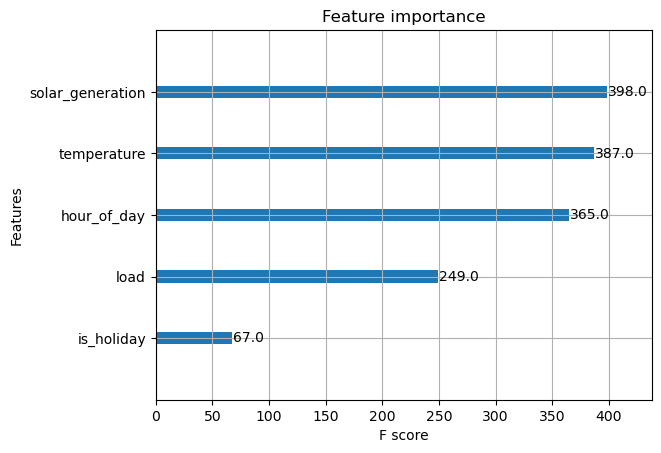

In [9]:
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), eval_metric='mlogloss', random_state=42)

xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# print(classification_report(y_test, y_pred, target_names=le.classes_))
print( confusion_matrix(y_test, y_pred))


xgb.plot_importance(xgb_clf)


In [10]:
xgb_reg = XGBRegressor(
    n_estimators=100,  
    learning_rate=0.1,  
    max_depth=6,  
    random_state=42  
)

In [11]:
xgb_reg.fit(X_train_reg, y_train_reg)

leb=LabelEncoder()
y_reg=leb.fit_transform(y_reg)
y_pred_reg = xgb_reg.predict(X_test_reg)

mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Mean Squared Error: 5401549.957162124
R² Score: 0.5516851020579168


In [12]:
def predict_for_date(date, temperature, solar_generation, hour_of_day, is_holiday, xgb_clf, xgb_reg, le):
    new_data_class = pd.DataFrame({
        'temperature': [temperature],
        'solar_generation': [solar_generation],
        'hour_of_day': [hour_of_day],
        'load': [0],
        'is_holiday': [is_holiday]
    })

    new_data_reg = pd.DataFrame({
        'temperature': [temperature],
        'solar_generation': [solar_generation],
        'hour_of_day': [hour_of_day],
        'is_holiday': [is_holiday]
    })
    
    predicted_class_label = xgb_clf.predict(new_data_class)
    predicted_compensation_method = le.inverse_transform(predicted_class_label)
    predicted_peak_supply = xgb_reg.predict(new_data_reg)

    return {
        'date': date,
        'hour_of_day': hour_of_day,
        'compensation_method': predicted_compensation_method[0],
        'peak_supply_needed': predicted_peak_supply[0]
    }

def generate_24_hour_predictions(timestamp, temperature, solar_generation, is_holiday, xgb_clf, xgb_reg, le):

    results = []

    hour=timestamp.hour
    
    prediction = predict_for_date(timestamp, temperature, solar_generation, hour, is_holiday, xgb_clf, xgb_reg, le)
    results.append(prediction)
    
    df_predictions = pd.DataFrame(results)
    
    return df_predictions


In [15]:
full_testdf=pd.read_csv('hourly data(2000-2023).csv')
full_testdf

,timestamp,day_of_week,hour_of_day,is_weekend,temperature,is_holiday,solar_generation,electricity_demand
0,2000-01-01 00:00:00,5,0,1,17.483571,0,0.853473,512.319382
1,2000-01-01 01:00:00,5,1,1,14.308678,0,4.869377,439.055673
2,2000-01-01 02:00:00,5,2,1,18.238443,0,4.997991,539.090652
3,2000-01-01 03:00:00,5,3,1,22.615149,0,2.738188,523.248968
4,2000-01-01 04:00:00,5,4,1,13.829233,0,7.694527,516.822822
...,...,...,...,...,...,...,...,...
210356,2023-12-30 20:00:00,5,20,1,10.287488,0,6.321843,614.952598
210357,2023-12-30 21:00:00,5,21,1,13.728469,0,4.988534,633.911183
210358,2023-12-30 22:00:00,5,22,1,12.069605,0,7.831031,616.891494
210359,2023-12-30 23:00:00,5,23,1,15.542929,0,2.843539,497.233142


In [16]:
full_testdf.drop('electricity_demand', axis=1, inplace=True)

In [17]:
testdf=pd.read_csv('24-hours testset.csv')

In [18]:
testdf['timestamp']=pd.to_datetime(testdf['timestamp'])

In [19]:
full_testdf['timestamp']=pd.to_datetime(full_testdf['timestamp'])

In [20]:
testdf

,timestamp,day_of_week,hour_of_day,is_weekend,temperature,is_holiday,solar_generation,electricity_demand
0,2024-01-01 00:00:00,0,0,0,28.534249,0,0.786249,633.109944
1,2024-01-01 01:00:00,0,1,0,18.140664,0,7.331477,537.356804
2,2024-01-01 02:00:00,0,2,0,19.539847,0,9.877753,562.069786
3,2024-01-01 03:00:00,0,3,0,17.519129,0,1.215103,483.268876
4,2024-01-01 04:00:00,0,4,0,18.255590,0,2.476539,579.301366
...,...,...,...,...,...,...,...,...
8756,2024-12-30 20:00:00,0,20,0,7.929691,0,4.235843,607.299343
8757,2024-12-30 21:00:00,0,21,0,10.136094,0,5.939992,551.692302
8758,2024-12-30 22:00:00,0,22,0,16.290948,0,0.673143,611.617725
8759,2024-12-30 23:00:00,0,23,0,18.676171,0,3.043134,634.507696


In [21]:
testdf.drop('electricity_demand', axis=1, inplace=True)

In [22]:
full_testdf

,timestamp,day_of_week,hour_of_day,is_weekend,temperature,is_holiday,solar_generation
0,2000-01-01 00:00:00,5,0,1,17.483571,0,0.853473
1,2000-01-01 01:00:00,5,1,1,14.308678,0,4.869377
2,2000-01-01 02:00:00,5,2,1,18.238443,0,4.997991
3,2000-01-01 03:00:00,5,3,1,22.615149,0,2.738188
4,2000-01-01 04:00:00,5,4,1,13.829233,0,7.694527
...,...,...,...,...,...,...,...
210356,2023-12-30 20:00:00,5,20,1,10.287488,0,6.321843
210357,2023-12-30 21:00:00,5,21,1,13.728469,0,4.988534
210358,2023-12-30 22:00:00,5,22,1,12.069605,0,7.831031
210359,2023-12-30 23:00:00,5,23,1,15.542929,0,2.843539


In [23]:
def generate_year_predictions(test_dataset, rf_clf, rf_reg, le):
    
    all_predictions = []

    for _, row in test_dataset.iterrows():
        timestamp = pd.to_datetime(row['timestamp'])
        temperature = row['temperature']
        solar_generation = row['solar_generation']
        is_holiday = row['is_holiday']

        # Generate predictions for each hour of the day
        daily_predictions = generate_24_hour_predictions(timestamp, temperature, solar_generation, is_holiday, xgb_clf, xgb_reg, le)
        all_predictions.append(daily_predictions)
    
    # Combine all daily predictions into one DataFrame
    df_all_predictions = pd.concat(all_predictions, ignore_index=True)
    
    return df_all_predictions


In [24]:
df_year_predictions = generate_year_predictions(full_testdf.tail(50000), xgb_clf, xgb_reg, le)

df_year_predictions

,date,hour_of_day,compensation_method,peak_supply_needed
0,2018-04-17 17:00:00,17,Normal Operation,19111.921875
1,2018-04-17 18:00:00,18,Peak Load Shifting,18582.720703
2,2018-04-17 19:00:00,19,Peak Load Shifting,19197.519531
3,2018-04-17 20:00:00,20,Peak Load Shifting,19326.724609
4,2018-04-17 21:00:00,21,Peak Load Shifting,19080.902344
...,...,...,...,...
49995,2023-12-30 20:00:00,20,Peak Load Shifting,23262.347656
49996,2023-12-30 21:00:00,21,Peak Load Shifting,22051.203125
49997,2023-12-30 22:00:00,22,Peak Load Shifting,22146.402344
49998,2023-12-30 23:00:00,23,Normal Operation,18650.832031


C:\Users\ASUS\AppData\Local\Temp\ipykernel_24076\3804829911.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df.head(100), x='hour_of_day', y='load', palette='Set1')


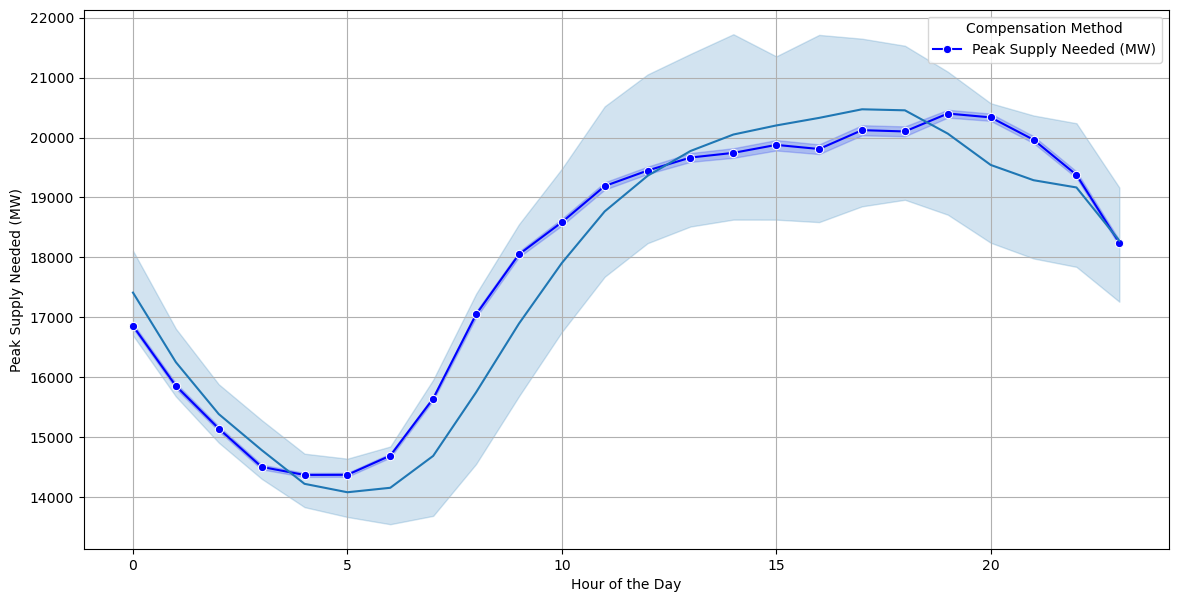

In [25]:
def plot_predictions(df_predictions):
    plt.figure(figsize=(14, 7))

    sns.lineplot(data=df_year_predictions, x='hour_of_day', y='peak_supply_needed', marker='o', color='blue', label='Peak Supply Needed (MW)')
    
    sns.lineplot(data=df.head(100), x='hour_of_day', y='load', palette='Set1')

    # plt.title('Hourly Predictions for {}'.format(df_predictions['date'][0]))
    plt.xlabel('Hour of the Day')
    plt.ylabel('Peak Supply Needed (MW)')
    plt.legend(title='Compensation Method')
    plt.grid(True)
    plt.show()

plot_predictions(df_year_predictions)

In [26]:
full_testdf['old_compensation']=df_year_predictions['compensation_method']

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [28]:
predicted_loads = df_year_predictions['peak_supply_needed'].head(8737)
actual_loads = df['load']

In [29]:
mae = mean_absolute_error(actual_loads, predicted_loads)
mse = mean_squared_error(actual_loads, predicted_loads)
rmse = np.sqrt(mse)
r2 = r2_score(actual_loads, predicted_loads)
mape = np.mean(np.abs((actual_loads - predicted_loads) / actual_loads)) * 100
accuracy = 100 - mape

# Print the results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
print(f"Accuracy: {accuracy:.4f}%")

Mean Absolute Error (MAE): 3882.3900
Mean Squared Error (MSE): 23095392.2930
Root Mean Squared Error (RMSE): 4805.7666
R-squared (R²): -1.0151
Mean Absolute Percentage Error (MAPE): 22.1653%
Accuracy: 77.8347%


In [30]:
predicted_metjod = df_year_predictions['compensation_method']
actual_loads = df['compensation_method'].head(2400)

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Assuming you have actual and predicted compensation methods
# 'y_true' is the actual compensation methods from your test dataset
# 'y_pred' is the predicted compensation methods from your model

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)


Accuracy: 0.9989
Confusion Matrix:
[[ 182    0    0    1    0]
 [   0  558    0    1    0]
 [   0    0   22    0    0]
 [   0    1    0 1372    0]
 [   0    0    0    0  485]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       183
           1       1.00      1.00      1.00       559
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00      1373
           4       1.00      1.00      1.00       485

    accuracy                           1.00      2622
   macro avg       1.00      1.00      1.00      2622
weighted avg       1.00      1.00      1.00      2622

